In [46]:
#import packages
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from cmdstanpy import CmdStanMCMC

In [47]:
#modify import path
import sys
sys.path.append('../our_analysis')

#import our code
from logreg import run_logistic_regression

In [48]:
#Set WD
notebook_dir = os.getcwd()

In [49]:
#load dataset
df = pd.read_csv("../dataset/all_subjects.csv")

story_trials = df[df["Condition"] == "story"]
abstract_trials=df[df["Condition"] == "abstract"]

##WE MIGHT NEED TO REMOVE THE SLOW pts
# //need to double check on that but this is what they did in the paper...and the reference data

Analysis includes 46 participants


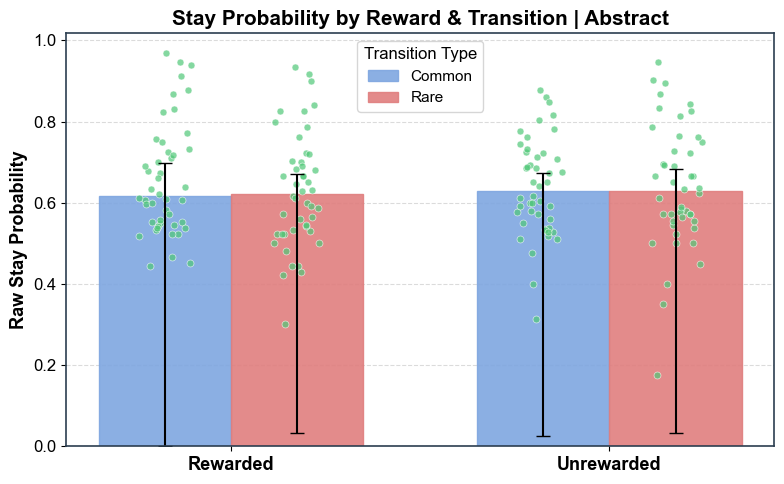

In [54]:

df = story_trials
# Calculate 'stay' for each trial (1 if current choice matches previous choice, 0 otherwise)
# We need to do this for each subject separately
subjects = df['Subject'].unique()

# Initialize stay column
df['stay'] = np.nan

for subject in subjects:
    subject_data = df[df['Subject'] == subject].copy()
    subject_data = subject_data.sort_values('trial')  # Make sure trials are in order
    
    # Calculate stay (compare current choice with previous choice)
    subject_data['stay'] = 0  # Default to not staying
    for i in range(1, len(subject_data)):
        if subject_data.iloc[i]['choice1'] == subject_data.iloc[i-1]['choice1']:
            subject_data.loc[subject_data.index[i], 'stay'] = 1
    
    # Update main dataframe
    df.loc[subject_data.index, 'stay'] = subject_data['stay']

# Drop first trial for each subject (because 'stay' can't be defined for it)
df = df.dropna(subset=['stay'])

# Get number of participants after filtering
participants = df['Subject'].unique()
n_participants = len(participants)
print(f"Analysis includes {n_participants} participants")

# Define the conditions
groups = ["Rewarded", "Unrewarded"]
transitions = ["Common", "Rare"]

# Initialize data structures to hold raw probabilities
raw_probs = {
    "Rewarded-Common": [],
    "Rewarded-Rare": [],
    "Unrewarded-Common": [],
    "Unrewarded-Rare": []
}

# Calculate stay probability for each participant in each condition
for pid in participants:
    subject_data = df[df['Subject'] == pid]
    
    for reward_val in [1, 0]:
        reward_label = "Rewarded" if reward_val == 1 else "Unrewarded"
        reward_data = subject_data[subject_data['reward'] == reward_val]
        
        for common_val in [1, 0]:
            transition_label = "Common" if common_val == 1 else "Rare"
            condition_data = reward_data[reward_data['common'] == common_val]
            
            # Calculate stay probability (proportion of trials where action is same as previous trial)
            if len(condition_data) > 0:
                stay_count = condition_data['stay'].sum()
                total_count = len(condition_data)
                stay_prob = stay_count / total_count
            else:
                stay_prob = np.nan
            
            # Store the probability
            condition_key = f"{reward_label}-{transition_label}"
            raw_probs[condition_key].append(stay_prob)

# Filter out NaN values
for key in raw_probs:
    raw_probs[key] = [p for p in raw_probs[key] if not np.isnan(p)]

# Calculate summary statistics
# Calculate summary statistics
common_vals = [raw_probs[f"{g}-Common"] for g in groups]
rare_vals = [raw_probs[f"{g}-Rare"] for g in groups]

common_meds = [np.median(vals) for vals in common_vals]
rare_meds = [np.median(vals) for vals in rare_vals]

# Calculate confidence intervals using standard error
def calculate_ci(vals, confidence=0.95):
    """Calculate confidence interval using standard error"""
    if len(vals) < 2:
        return [0, 0]  # Default to zero width if not enough data
    
    mean = np.mean(vals)
    sem = np.std(vals, ddof=1) / np.sqrt(len(vals))
    # For 95% CI, use multiplier of 1.96
    multiplier = 1.96
    lower = max(0, mean - multiplier * sem)  # Ensure non-negative
    upper = min(1, mean + multiplier * sem)  # Ensure doesn't exceed 1 (probability)
    return [lower, upper]

common_cis = [calculate_ci(vals) for vals in common_vals]
rare_cis = [calculate_ci(vals) for vals in rare_vals]

# Plotting
x = np.arange(len(groups))
width = 0.35

plt.rcParams.update({'font.family': 'Arial', 'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')

# Common transitions
ax.bar(
    x - width/2,
    common_meds,
    width,
    yerr=np.array([
        np.array([min(m, l) for m, (l, h) in zip(common_meds, common_cis)]),  # Ensure non-negative
        np.array([max(0, h - m) for m, (l, h) in zip(common_meds, common_cis)])  # Ensure non-negative
    ]),
    capsize=5,
    color="#7EA6E0",     
    edgecolor="#7EA6E0", 
    label="Common",
    alpha=0.9,
)

# Rare transitions
ax.bar(
    x + width/2,
    rare_meds,
    width,
    yerr=np.array([
        np.array([min(m, l) for m, (l, h) in zip(rare_meds, rare_cis)]),  # Ensure non-negative
        np.array([max(0, h - m) for m, (l, h) in zip(rare_meds, rare_cis)])  # Ensure non-negative
    ]),
    capsize=5,
    color="#E07E7E",     
    edgecolor="#E07E7E",
    label="Rare",
    alpha=0.9,
)

# Add individual data points
dot_color = "#50C878"
for i, g in enumerate(groups):
    # Common dots
    cur_vals = raw_probs[f"{g}-Common"]
    n_pts = len(cur_vals)
    
    jitter = (np.random.rand(n_pts) - 0.5) * width * 0.4
    ax.scatter(
        np.full(n_pts, x[i] - width/2) + jitter,
        cur_vals,
        color=dot_color,
        alpha=0.7,
        s=25,
        edgecolor='white',
        linewidth=0.5
    )
    
    # Rare dots
    cur_vals = raw_probs[f"{g}-Rare"]
    n_pts = len(cur_vals)
    
    jitter = (np.random.rand(n_pts) - 0.5) * width * 0.4
    ax.scatter(
        np.full(n_pts, x[i] + width/2) + jitter,
        cur_vals,
        color=dot_color,
        alpha=0.7,
        s=25,
        edgecolor='white',
        linewidth=0.5
    )

# Set labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=13, fontweight='bold')
ax.set_ylabel("Raw Stay Probability", fontsize=13, fontweight='bold')
ax.set_title("Stay Probability by Reward & Transition | Abstract", fontsize=15, fontweight='bold')
ax.legend(title="Transition Type", fontsize=11, title_fontsize=12)

ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('#2C3E50')

plt.tight_layout()
plt.show()

In [16]:
fit = run_logistic_regression("../dataset/beh_noslow.csv")


12:16:39 - cmdstanpy - INFO - created output directory: /Users/nokada/Documents/CALTECH/sdn_hw2/our_analysis/analysis_results/logreg_samples
12:16:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |          | 00:04 Iteration:     1 / 48000 [  0%]  (Warmup)


chain 1 |          | 00:05 Iteration:   100 / 48000 [  0%]  (Warmup)


chain 1 |          | 00:07 Iteration:   200 / 48000 [  0%]  (Warmup)


chain 1 |          | 00:08 Iteration:   300 / 48000 [  0%]  (Warmup)


chain 1 |          | 00:09 Iteration:   400 / 48000 [  0%]  (Warmup)


chain 1 |▏         | 00:10 Iteration:   500 / 48000 [  1%]  (Warmup)


chain 1 |▏         | 00:11 Iteration:   600 / 48000 [  1%]  (Warmup)


chain 1 |▏         | 00:12 Iteration:   700 / 48000 [  1%]  (Warmup)



chain 1 |▏         | 00:14 Iteration:   800 / 48000 [  1%]  (Warmup)


chain 1 |▏         | 00:15 Iteration:   900 / 48000 [  1%]  (Warmup)


chain 1 |▏         | 00:16 Iteration:  1000 / 48000 [ 


12:26:12 - cmdstanpy - INFO - CmdStan done processing.
12:26:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/Users/nokada/Documents/CALTECH/sdn_hw2/our_analysis/logreg_model.stan', line 33, column 4 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/Users/nokada/Documents/CALTECH/sdn_hw2/our_analysis/logreg_model.stan', line 33, column 4 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[3] is 0, but must be positive! (in '/Users/nokada/Documents/CALTECH/sdn_hw2/our_analysis/logreg_model.stan', line 33, column 4 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/Users/nokada/Documents/CALTECH/sdn_hw2/our_analysis/logreg_model.stan', line 33, column 4 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/Users/nokada/Docum

In [24]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-6487.150000,0.233080,24.391500,23.158200,-6524.680000,-6488.460000,-6444.910000,11992.1,12885.0,1.00043
"coefs[1,1]",1.113130,0.001191,0.427295,0.403611,0.478845,1.077970,1.867340,145717.0,76095.7,1.00018
"coefs[1,2]",-0.094735,0.000953,0.267334,0.234373,-0.570100,-0.065899,0.284694,85847.0,72313.1,1.00004
"coefs[1,3]",0.815087,0.000828,0.298918,0.282334,0.365262,0.795535,1.332240,137636.0,84081.6,1.00006
"coefs[1,4]",2.646060,0.001475,0.484001,0.456922,1.949520,2.594010,3.524440,127148.0,76232.5,1.00009
...,...,...,...,...,...,...,...,...,...,...
"Sigma[3,4]",0.105941,0.000096,0.030971,0.029468,0.060769,0.102961,0.161531,103625.0,103091.0,1.00001
"Sigma[4,1]",0.142996,0.000164,0.057579,0.055070,0.056338,0.138699,0.244221,130676.0,83486.2,1.00001
"Sigma[4,2]",0.000240,0.000077,0.019651,0.018495,-0.032496,0.000562,0.031687,65608.8,87413.5,1.00003
"Sigma[4,3]",0.105941,0.000096,0.030971,0.029468,0.060769,0.102961,0.161531,103625.0,103091.0,1.00001


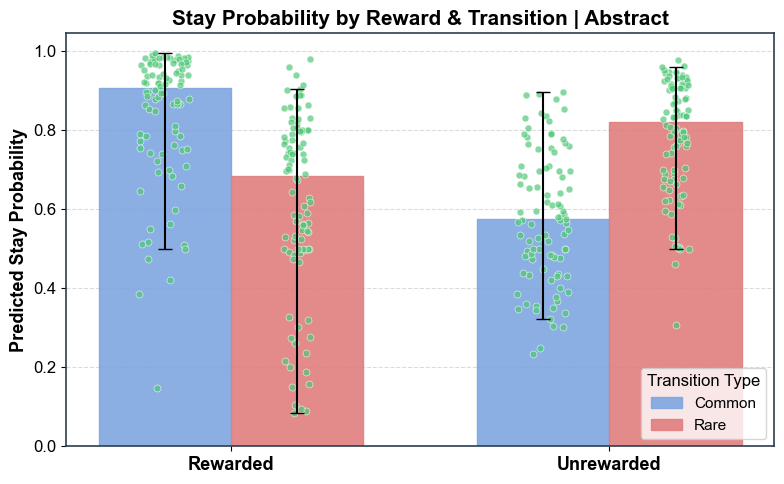

In [38]:
posterior = fit.draws_pd()

n_participants = 94  #need to double check number of pts. Also need to decide whether or not to model with slow/noslow
## i think i need to reduce the n to restrict to only model the abstract condition pts.

#four possible combinations
conds = {
    "Rewarded-Common":   ( 1,  1),
    "Rewarded-Rare":     ( 1, -1),
    "Unrewarded-Common": (-1,  1),
    "Unrewarded-Rare":   (-1, -1),
}

#use fits to compute the logit for each possible condition
participant_meds = {name: [] for name in conds}
for pid in range(1, n_participants + 1):
    b0  = posterior[f"coefs[{pid},1]"]
    br  = posterior[f"coefs[{pid},2]"]
    bt  = posterior[f"coefs[{pid},3]"]
    bir = posterior[f"coefs[{pid},4]"]
    for name, (xr, xt) in conds.items():
        lin = b0 + br*xr + bt*xt + bir*(xr*xt)
        ps  = 1 / (1 + np.exp(-lin))      # logistic
        participant_meds[name].append(np.median(ps))

#Split groups
groups      = ["Rewarded", "Unrewarded"]
common_vals = [participant_meds[f"{g}-Common"] for g in groups]
rare_vals   = [participant_meds[f"{g}-Rare"]   for g in groups]

#compute group stats
common_meds = [np.median(vals) for vals in common_vals]
rare_meds   = [np.median(vals) for vals in rare_vals]
common_hdis = [az.hdi(np.array(vals), hdi_prob=0.95) for vals in common_vals]
rare_hdis   = [az.hdi(np.array(vals), hdi_prob=0.95) for vals in rare_vals]

#plotting
x     = np.arange(len(groups))
width = 0.35

plt.rcParams.update({'font.family': 'Arial', 'font.size': 12})
fig, ax = plt.subplots(figsize=(8,5), facecolor='white')

#common
ax.bar(
    x - width/2,
    common_meds,
    width,
    yerr=np.array([
        [m - lo for m, (lo, hi) in zip(common_meds, common_hdis)],
        [hi - m for m, (lo, hi) in zip(common_meds, common_hdis)]
    ]),
    capsize=5,
    color="#7EA6E0",     
    edgecolor="#7EA6E0", 
    label="Common",
    alpha=0.9,
)
#rare
ax.bar(
    x + width/2,
    rare_meds,
    width,
    yerr=np.array([
        [m - lo for m, (lo, hi) in zip(rare_meds, rare_hdis)],
        [hi - m for m, (lo, hi) in zip(rare_meds, rare_hdis)]
    ]),
    capsize=5,
    color="#E07E7E",     
    edgecolor="#E07E7E",
    label="Rare",
    alpha=0.9,
)

dot_color = "#50C878"  
for i, g in enumerate(groups):
    # Common dots
    jitter = (np.random.rand(n_participants) - 0.5) * width * 0.4
    ax.scatter(
        np.full(n_participants, x[i] - width/2) + jitter,
        common_vals[i],
        color=dot_color,
        alpha=0.7,
        s=25,
        edgecolor='white',
        linewidth=0.5
    )
    # Rare dots
    jitter = (np.random.rand(n_participants) - 0.5) * width * 0.2
    ax.scatter(
        np.full(n_participants, x[i] + width/2) + jitter,
        rare_vals[i],
        color=dot_color,
        alpha=0.7,
        s=25,
        edgecolor='white',
        linewidth=0.5
    )
ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=13, fontweight='bold')
ax.set_ylabel("Predicted Stay Probability", fontsize=13, fontweight='bold')
ax.set_title("Stay Probability by Reward & Transition | Abstract", fontsize=15, fontweight='bold')
ax.legend(title="Transition Type", fontsize=11, title_fontsize=12)

ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('#2C3E50')

plt.tight_layout()
plt.show()